In [5]:
import os

os.environ['CRDS_PATH'] = '/home/tdewachter/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit as cfit
from astropy.visualization import ZScaleInterval

In [154]:
def gaussian(x,x0,A,s):
    return A * np.exp(-(x-x0)**2 / (2*s**2))

def slitlet(x,x1,x2,x3,A1,A2,A3,s):
    return gaussian(x,x1,A1,s) + gaussian(x,x2,A2,s) + gaussian(x,x3,A3,s)

def doTheFit(x,y,peaks):
    X = np.linspace(0,len(x),100)
    coeff, err, info, msg, ier = cfit(slitlet, x, y, p0=[*peaks,*y[peaks],0.5],full_output=True)
    print(msg)
    print(coeff)
    plt.plot(X,slitlet(X,*coeff))

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[ 7.25242237 12.37904341 17.43584244  0.10881428  0.10906323  0.11240519
  1.65941789]


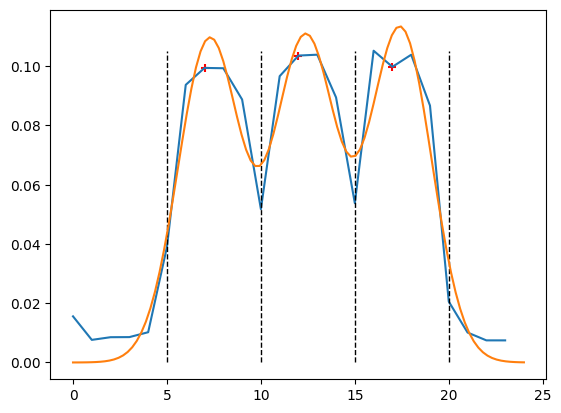

In [47]:
name = "jw01345063001_03101_00001_nrs1_srctype.fits"
multi_hdu = fits.open(name)

for i,hdu in enumerate(multi_hdu):
    if not hdu.name == 'SCI':
        continue
    hdr = hdu.header
    data = np.ma.array(hdu.data, mask=np.isnan(hdu.data))

    shutter_id = WhichShutterOpen(hdr)
    if shutter_id == None:
        continue

    # Get vertical cross section by summing horizontally
    horiz_sum = np.mean(data,axis=1)

    # Determine 3 maxima for 3 slits
    peaks = []
    j = 2
    while not len(peaks) == 3:
        if j > 6:
            break
        peaks = find_peaks_cwt(horiz_sum,j)
        j += 1
    if not len(peaks) == 3:
        continue

    peaks[1:] -=1
    
    # Cut horizontally at midpoint between maxima -> 3 strips
    slice_indices = getPeakSlice(peaks,0,len(horiz_sum))
    
    plt.figure()
    #horiz_sum -= horiz_sum.min()
    plt.plot(horiz_sum)
    plt.scatter(peaks,horiz_sum[peaks],marker='+',color="r")
    plt.vlines([5,10,15,20],0,horiz_sum.max(),color='k',linestyle='dashed',linewidth=1)
    
    doTheFit(range(len(horiz_sum)),horiz_sum,peaks)
    
    
    
    break
    
    # Get 2 background strips
    #TODO : Support for different height strips
    src = data[slice_indices[shutter_id][0]:slice_indices[shutter_id][1],:]
    bkg1 = data[slice_indices[shutter_id-1][0]:slice_indices[shutter_id-1][1],:]
    bkg2 = data[slice_indices[shutter_id-2][0]:slice_indices[shutter_id-2][1],:]


    # Determine non background sources : sudden spikes, high correlation with source strip -> flag pixels
    # TODO : Better background detection
    threshold = 0.3
    mask1 = bkg1 > bkg1.min() + (bkg1.max() - bkg1.min())*threshold
    mask2 = bkg2 > bkg2.min() + (bkg2.max() - bkg2.min())*threshold

    bkg1_keep = np.ma.array(bkg1,mask=mask1,fill_value=np.nan)
    bkg2_keep = np.ma.array(bkg2,mask=mask2,fill_value=np.nan)

    height = min(bkg1_keep.shape[0],bkg2_keep.shape[0])

    bkg_master = np.ma.dstack((bkg1_keep[:height,:],bkg2_keep[:height,:])).mean(axis=2)
    mask_master = np.ma.getmask(bkg_master)



    # Remove pixels + interpolate on a given strip (ignore source strip)
    non_nan = np.where(np.logical_not(mask_master))
    x = non_nan[0]
    y = non_nan[1]
    z = bkg_master[non_nan]

    interp = NNExtrapolation(np.c_[x, y], z)

    X = np.arange(bkg_master.shape[0])
    Y = np.arange(bkg_master.shape[1])
    YY,XX = np.meshgrid(Y,X)
    bkg_interp = interp(XX,YY)

    """
    plt.figure()

    plt.subplot(4,1,1)
    plt.title("Background")
    plt.imshow(bkg1[:height,:],interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,2)
    plt.title("Master Background")
    plt.imshow(bkg_master,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,3)
    plt.title("Nearest Neighbour")
    plt.imshow(bkg_interp,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,4)
    plt.title("Inverse Distance Weighting")
    interp = IDWExtrapolation(np.c_[x,y], z,power = 3)
    bkg_interp = interp(XX,YY)
    plt.imshow(bkg_interp,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())

    plt.savefig(str(i)+".png")
    plt.close()
    """
multi_hdu.close()
plt.show(block=False)

In [55]:
data = np.zeros((10,10))
data[:,:] = np.nan
data[2:4,:] = 1

non_nan = np.where(np.logical_not(np.isnan(data)))
print(data)
print(non_nan)

print(data[non_nan])

[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]
(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [3]:
def IDWExtrapolation(xy, ui, power=1):
    """
    Rough implementation of the Inverse Distance Weighting algorithm

    Parameters
    ----------
    xy : ndarray, shape (npoints, ndim)
        Coordinates of data points
    ui : ndarray, shape (npoints)
        Values at data points

    Returns
    -------
    func : callable
    """
    x = xy[:, 0]
    y = xy[:, 1]

    def new_f(xx,yy):

        xy_ravel = np.column_stack((xx.ravel(),yy.ravel()))
        x_ravel = xy_ravel[:, 0]
        y_ravel = xy_ravel[:, 1]

        X1, X2 = np.meshgrid(x,x_ravel)
        Y1, Y2 = np.meshgrid(y,y_ravel)

        d = ((X1-X2)**2 + (Y1-Y2)**2).T

        w = d**(-power/2)

        w_ui_sum = ui[:, None]*w
        w_ui_sum = w_ui_sum.sum(axis=0)

        wsum = w.sum(axis=0)

        result = w_ui_sum / wsum
        result = result.reshape(np.shape(xx))
        result[x,y] = ui

        return result

    return new_f




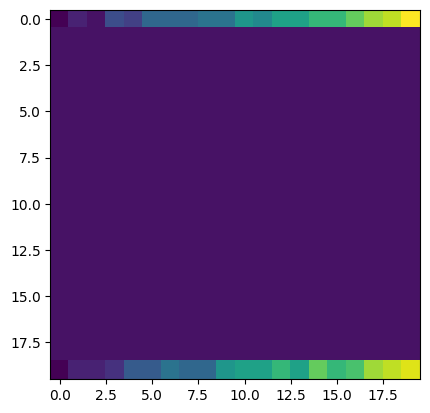

/tmp/ipykernel_6248/3440803820.py:30: RuntimeWarning: divide by zero encountered in power
  w = d**(-power/2)
/tmp/ipykernel_6248/3440803820.py:37: RuntimeWarning: invalid value encountered in divide
  result = w_ui_sum / wsum


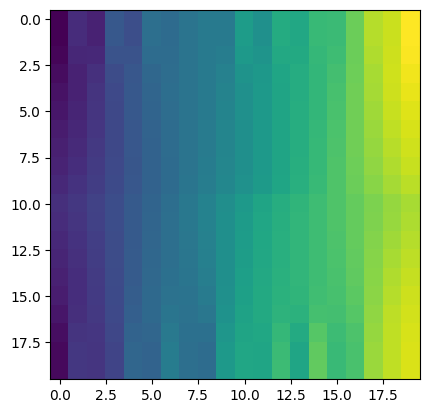

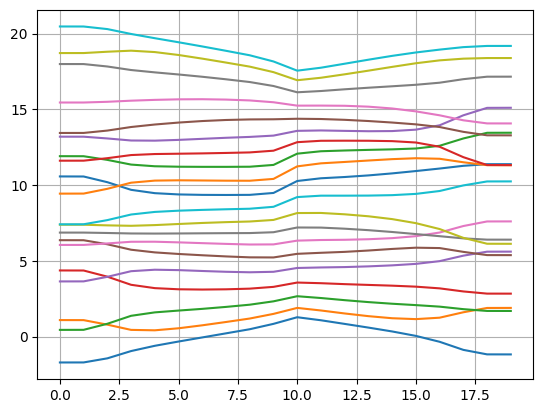

[-0.23169992  1.21361055  1.79820544  3.37754973  4.5412978   5.63892136
  6.47223051  6.82263672  7.39942754  8.84034498 10.30456419 10.79160013
 12.02344324 12.20224974 13.56016973 13.94632933 15.17097503 16.992351
 18.10894205 19.01476072]


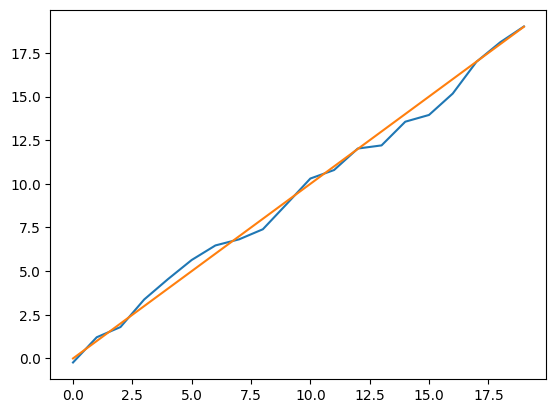

In [279]:
x = np.zeros(20,dtype=np.int8)
y = np.arange(20)
x = np.append(x,np.ones(20,dtype=np.int8)*19)
y = np.append(y,np.arange(20))
ui = np.append(np.arange(20),np.arange(20)) + np.random.random(40)*4 - 2


Y,X = np.meshgrid(np.arange(20),np.arange(20))
Z = np.zeros_like(X)
Z[x,y] = ui

plt.figure()
plt.imshow(Z)
plt.show()

interp = IDWExtrapolation(np.c_[x,y],ui,power=20)

z = interp(X,Y)

plt.figure()
plt.imshow(z)
plt.show()

plt.figure()
plt.plot(z)
plt.grid()
plt.show()

print(z.mean(axis=0))

plt.figure()
plt.plot(z.mean(axis=0),label="Interpolated")
plt.plot(np.arange(20))

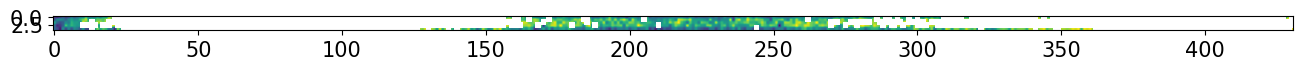

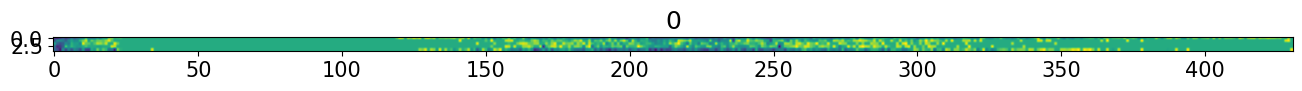

/tmp/ipykernel_1158/3440803820.py:30: RuntimeWarning: divide by zero encountered in power
  w = d**(-power/2)
/tmp/ipykernel_1158/3440803820.py:37: RuntimeWarning: invalid value encountered in divide
  result = w_ui_sum / wsum


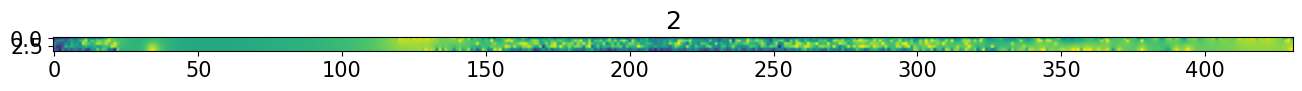

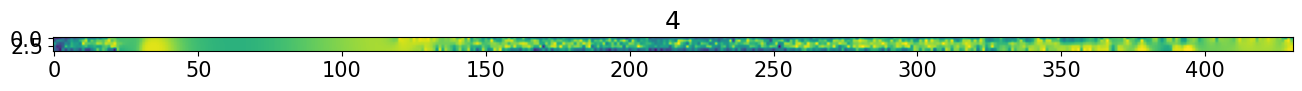

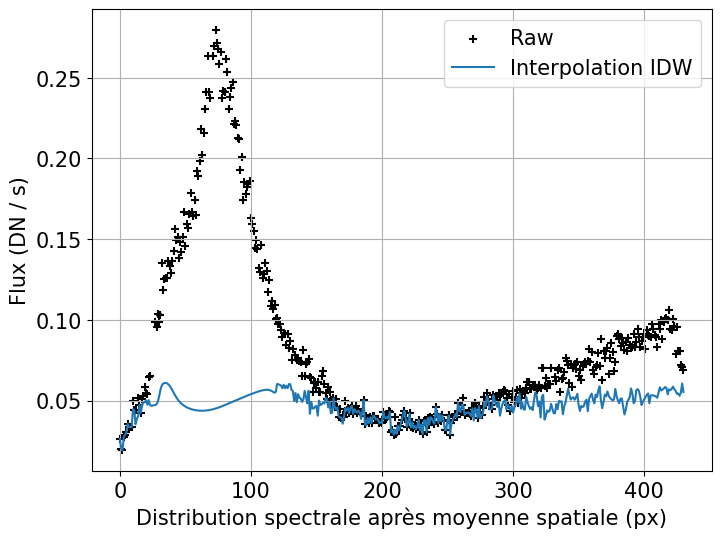

In [19]:
data = np.load("test-data.npy")
plt.rcParams["font.size"] = "15"
mask = data < np.nanquantile(data[~ np.isnan(data)].ravel(), 0.5)

data = np.ma.array(data,mask=~mask,fill_value=np.nan)

plt.figure(figsize=(16,8))
plt.imshow(data)
plt.show()

non_nan = np.where(mask)
x = non_nan[0]
y = non_nan[1]
z = data[non_nan]
z = np.ma.getdata(z)

for p in range(3):
    
    interp = IDWExtrapolation(np.c_[x, y], z, power=2*p)
    X = np.arange(data.shape[0])
    Y = np.arange(data.shape[1])
    YY,XX = np.meshgrid(Y,X)
    img = interp(XX,YY)


    plt.figure(figsize=(16,8)) 
    z1, z2 = ZScaleInterval().get_limits(img)
    plt.imshow(img,vmax=np.max(data),vmin=np.min(data))
    plt.title(2*p)
    plt.show()


plt.figure(figsize=(8,6))
yy = np.load("test-data.npy").mean(axis=0)
xx = np.arange(0,len(yy),1)
plt.scatter(xx,yy,label="Raw",color='k',marker='+')
for p in range(3):
    if not p == 2:
        continue
    interp = IDWExtrapolation(np.c_[x, y], z, power=2*p)
    X = np.arange(data.shape[0])
    Y = np.arange(data.shape[1])
    YY,XX = np.meshgrid(Y,X)
    img = interp(XX,YY)
    
    plt.plot(img.mean(axis=0),label="Interpolation IDW")
    plt.legend()
plt.grid()
plt.xlabel("Distribution spectrale après moyenne spatiale (px)")
plt.ylabel("Flux (DN / s)")
plt.show()

In [15]:
def IDWExtrapolation(xy, ui, power=1):
    x = xy[:, 0]
    y = xy[:, 1]
    def new_f(xx,yy):

        xy_ravel = np.column_stack((xx.ravel(),yy.ravel()))
        x_ravel = xy_ravel[:, 0]
        y_ravel = xy_ravel[:, 1]
        

        X1, X2 = np.meshgrid(x,x_ravel)
        Y1, Y2 = np.meshgrid(y,y_ravel)

        d = ((X1-X2)**2 + (Y1-Y2)**2).T

        w = np.zeros_like(d,dtype=float)
        

        w[d>0] = d[d>0]**(-power/2)
        

        w_ui_sum = ui[:, None]*w
        w_ui_sum = w_ui_sum.sum(axis=0)

        wsum = w.sum(axis=0)

        result = w_ui_sum / wsum
        result = result.reshape(np.shape(xx))

        result[x,y] = ui
        
        return result

    return new_f

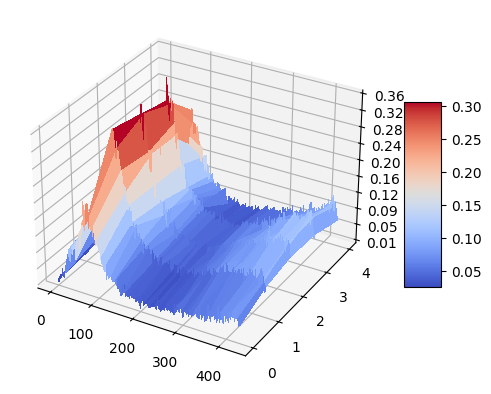

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D

data = np.load("test-data.npy")
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(data.shape[1])
Y = np.arange(data.shape[0])
X, Y = np.meshgrid(X, Y)
Z = data

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [4]:
def polyn_ravel(X,a,b,c,d,e,f,g):
    x,y = X
    return np.ravel(a*x*x + b*y*y + d*x + e*y + g + c*y**3)

def polyn(X,a,b,c,d,e,f,g):
    return a*x*x + b*y*y + d*x + e*y + g + c*y**3

Fitted parameters:
[-4.26014709e-02  5.80928050e-03 -5.75386531e-05  1.90977459e-07
 -2.04520138e-10  1.09074873e-01 -3.03683553e-04  4.58859683e-07
  2.03045979e-10 -6.46412307e-02  7.34299733e-05 -1.14288145e-07
  1.92963096e-02 -5.97606426e-07 -2.45404277e-03]
RMS residual = nan


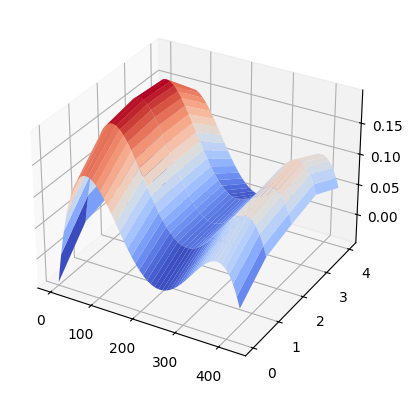

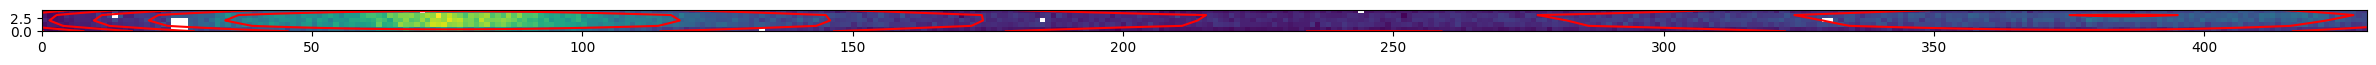

In [19]:
%matplotlib inline

def get_basis(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis.append(x**j * y**i)
    return basis

data = np.load("test-data.npy")
data[np.isnan(data)] = 0

Y,X = np.indices(np.shape(data))

x, y = X.ravel(), Y.ravel()
# Maximum order of polynomial term in the basis.
max_order = 4
basis = get_basis(x, y, max_order)

# Linear, least-squares fit.
A = np.vstack(basis).T
b = data.ravel()
c, r, rank, s = np.linalg.lstsq(A, b, rcond=None)

print('Fitted parameters:')
print(c)

# Calculate the fitted surface from the coefficients, c.
fit = np.sum(c[:, None, None] * np.array(get_basis(X, Y, max_order))
                .reshape(len(basis), *X.shape), axis=0)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, fit, cmap=cm.coolwarm)
plt.show()

# Plot the test data as a 2D image and the fit as overlaid contours.
fig = plt.figure(figsize=(30,4))
ax = fig.add_subplot(111)
ax.imshow(Z, origin='lower', cmap='viridis',
          extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(X, Y, fit, colors='r')
plt.show()



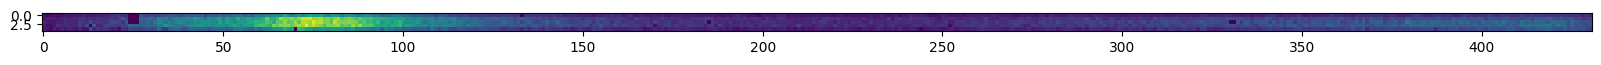

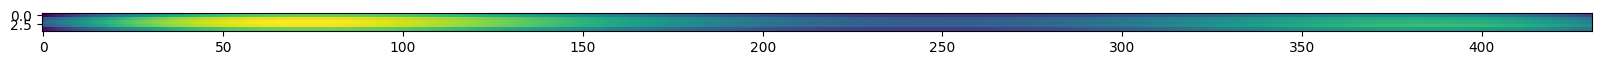

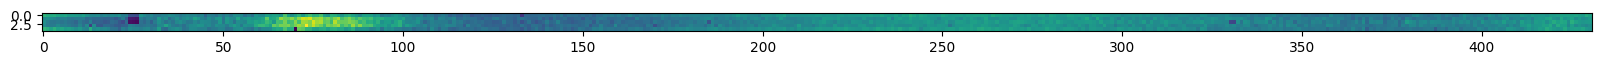

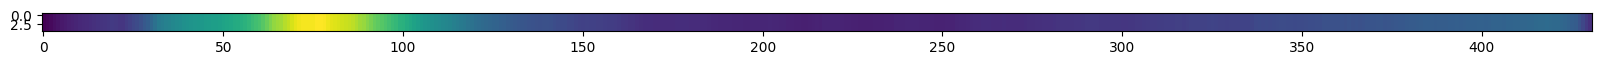

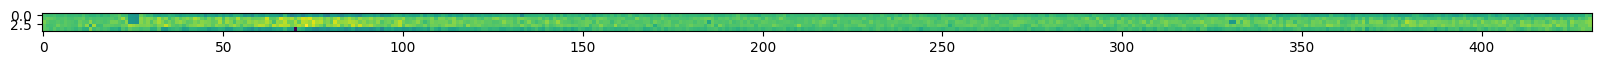

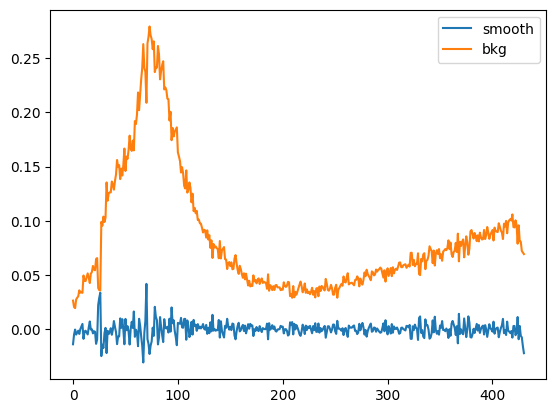

In [50]:
from scipy.signal import fftconvolve as conv 

plt.figure(figsize=(20,2))
plt.imshow(Z)
plt.show()

plt.figure(figsize=(20,2))
plt.imshow(fit)
plt.show()

plt.figure(figsize=(20,2))
plt.imshow(Z - fit)
plt.show()

plt.figure(figsize=(20,2))
n = 10
kernel = np.ones((n,n))/n**2 * 2
Z[np.isnan(Z)] = 0
smooth = conv(Z,kernel,mode="same")
plt.imshow(smooth)
plt.show()

plt.figure(figsize=(20,2))
plt.imshow(Z - smooth)
plt.show()

plt.figure()
plt.plot(smooth.mean(axis=0)-Z.mean(axis=0),label='smooth')
plt.plot(Z.mean(axis=0),label="bkg")
plt.legend()
plt.show()